# Local Depth Exploration

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import progressbar

In the Geenens manuscript, depth at a point $x$ is quantified by the following (Equation 3.1):
\begin{equation}
   DD(x,P) = P(d(X_1, X_2) > \max(d(x,X_1), d(x,X_2)))
\end{equation}
This can be thought of as quantifying "inclusion," i.e., if $x$ is "between" the randomly chosen $X_1$ and $X_2$, then the distance from $X_1$ to $X_2$ will be greater than both the distance from $x$ to $X_1$ and the distance from $x$ to $X_2$.

The focus on local depth is less on being "between" observations from $P$, but on being "close" to random draws from $P$. For example, in the canonical univariate, bimodal example, draws from $P$ are more likely to be close to either of the modes.

So, the idea here is to try to quantify local depth by balancing these two effects. Just as the local depth paper you shared has a tuning parameter, here the tuning parameter is a factor which balances these two contributions.

This just illustrates a simple example. Generate the random sample.

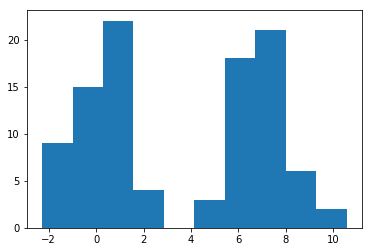

In [2]:
nsim = 100
xsim = norm.rvs(size=nsim)
xsim = np.concatenate((norm.rvs(size=int(nsim/2)), norm.rvs(7,size=int(nsim/2))),axis=None)
plt.hist(xsim)
plt.show()

## Just quantify what this is doing mathematically:


The new proposed approach below matches formulation in "Local depth" by Agostinelli & Romanazzi (2011). I'd want to think about this more - but this seems just like their local depth based on simplicial depth (Liu 1990).

### Probablistically:

Geenen's:
$$
𝐷𝐷(𝑥,𝑃)=𝑃[𝑑(𝑋1,𝑋2)>max(𝑑(𝑥,𝑋1),𝑑(𝑥,𝑋2))]
$$

Geenen's + Agostinelli & Romanazzi (2011) / Liu (1990):
$$
LDD_\tau(x,P) = 𝐷𝐷(𝑥,𝑃 | P \in B(x, \tau))
$$

### Empirically:

Geenen's:
$$
𝐷𝐷(𝑥,\hat{P})= \frac{1}{n \choose 2}\sum_{i\neq j}[𝑑(𝑋_i,𝑋_j)>max(𝑑(𝑥,𝑋_i),𝑑(𝑥,𝑋_j))] 
$$

Geenen's + Agostinelli & Romanazzi (2011) / Liu (1990):
$$
DD_\alpha(x,P) = 𝐷𝐷(𝑥,\hat{P}|\hat{P} \text{ defined on } B(x, \tau)) 
$$




# Data Depth Attempt

I'm just very used to "Data Depth" being defined more close to the depth of actual points in the space. Though I see that your definition can quickly give you depth for points not in the space.

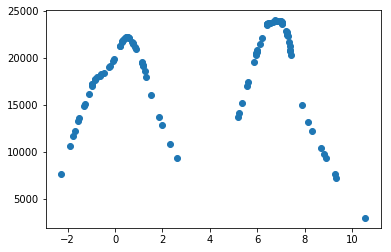

In [8]:
plt.scatter(xsim,holddepth_sim)
plt.show()

# Multi-Dimensional

In [9]:
import scipy.spatial # for distance matrix
# scipy.spatial.distance_matrix

In [10]:
x = np.concatenate([xsim.reshape((-1,1)), np.zeros((xsim.shape[0],1))], axis = 1)
dist_matrix = scipy.spatial.distance_matrix(x = x, y = x)


## Some functions to help with calculation:
Just putting your approach in some functions. (Structure from TC code)

In [11]:
def remove_idx(i,n):
    return np.concatenate([np.arange(i),np.arange(i+1,n)])

### A different approach to local depth

The proposed approach below matches formulation in "Local depth" by Agostinelli & Romanazzi (2011). I'd want to think about this more - but this **seems** just like their local depth based on simplicial depth (Liu 1990).

In [56]:
def local_distance_depth_function(dist_matrix, tau = np.inf):
    """
    calculates a depth vector using a distance matrix

    Arguments:
    ----------
    dist_matrix: np.array (n,n)
        square positive symmetric matrix
    tau : non-negative scalar constains which 

    Returns:
    --------
    depth: np.array (n,) 
        vector with depth values associated with indices in dist_matrix
    """
    N = dist_matrix.shape[0]
    
    if (N != dist_matrix.shape[1]) or \
        (np.any(dist_matrix.T != dist_matrix)) or \
        (np.any(dist_matrix < 0)):
        stop("this is not a positive symmetric square matrix")

    depth = np.zeros(N)
  

    for obs_index in np.arange(N):
        # vector of idx to keep (not associated with idx examining) 
        rm_idx = remove_idx(obs_index, N)
        # from symmetry:
        dist_to_obs = dist_matrix[obs_index, rm_idx]
        keep_idx = rm_idx[dist_to_obs <= tau]
        
        sub_matrix = dist_matrix[keep_idx,][:,keep_idx]
        N_inner = sub_matrix.shape[0]
        
        obs_column = dist_matrix[keep_idx,obs_index]
        obs_row    = dist_matrix[obs_index,keep_idx]
        
        obs_column_matrix = np.tile(obs_column, (N_inner,1))
        obs_row_matrix    = np.tile(obs_column, (N_inner,1)).T 
        
        obs_combo_array = np.zeros((N_inner, N_inner, 2))
        obs_combo_array[:,:,0] = obs_column_matrix
        obs_combo_array[:,:,1] = obs_row_matrix

        max_matrix = obs_combo_array.max(axis = 2)

        min_matrix = obs_combo_array.min(axis = 2)

        max_part = np.mean((sub_matrix > max_matrix)[
            ~np.eye(min_matrix.shape[0],dtype=bool) #ignore diagonal
        ])

        
        depth[obs_index] = max_part
    return(depth)

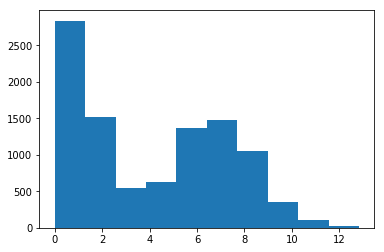

In [27]:
plt.hist(dist_matrix[~np.eye(dist_matrix.shape[0], dtype = bool)]);

In [57]:
tau_list = [.5,1.,2,3,4,6,8,10,np.inf]

bar = progressbar.ProgressBar()
ldd = list()
for tau in bar(tau_list):
    ldd.append(local_distance_depth_function(dist_matrix, tau))

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


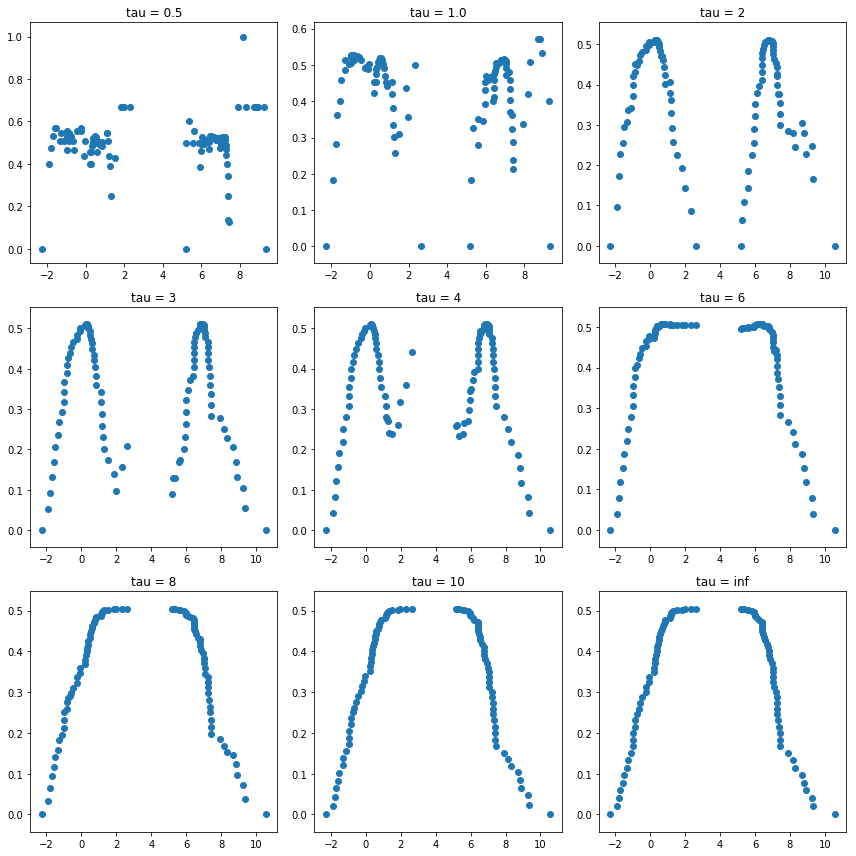

In [58]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
ax = ax.ravel()

for idx, tau in enumerate(tau_list):
    ldd_tau_i = ldd[idx]
    ax[idx].scatter(x = xsim, y = ldd_tau_i)
    ax[idx].set_title("tau = " + str(tau))
fig.tight_layout()

### 1D quality check #2

New $X = 10\cdot X$:


The below analysis worries me shouldn't worry me any more - a quick scaling of tau by $10^d$ ($d = 1$) is enough to correct for this (aka affine invariant). 

In [54]:
x_larger = np.concatenate([xsim.reshape((-1,1))*10, 
                           np.zeros((xsim.shape[0],1))], axis = 1)
dist_matrix_larger = scipy.spatial.distance_matrix(x = x_larger, 
                                                   y = x_larger)

In [61]:
tau_list = np.array([.5,1.,2,3,4,6,8,10,np.inf]) * 10

bar = progressbar.ProgressBar()
ldd_larger = list()
for tau in bar(tau_list):
    ldd_larger.append(local_distance_depth_function(dist_matrix_larger, tau))

100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


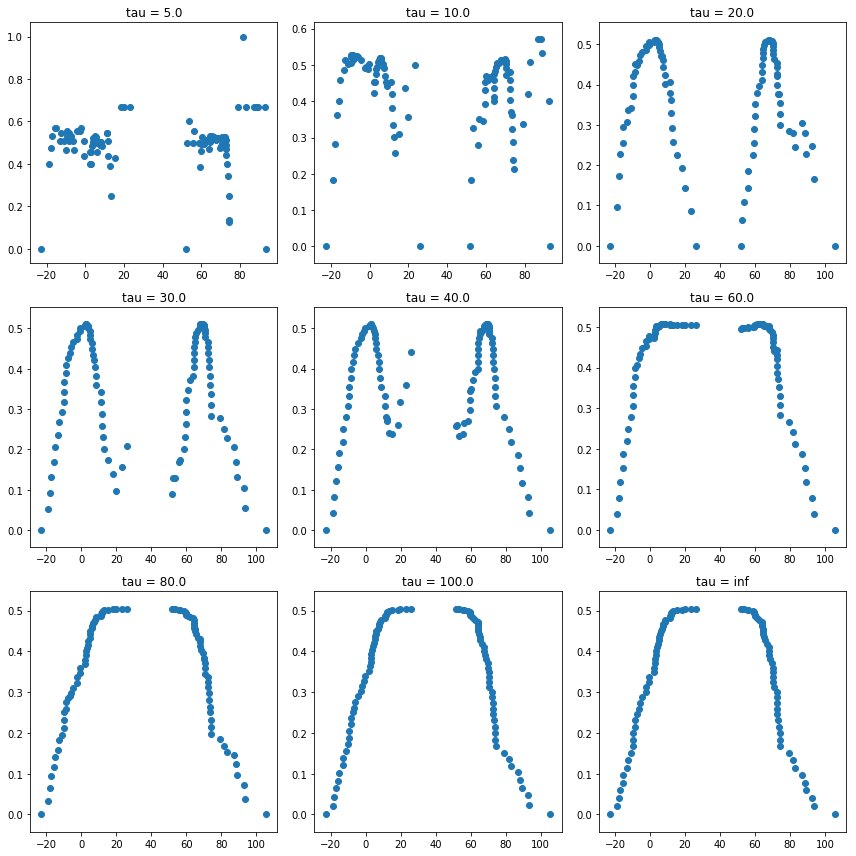

In [69]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
ax = ax.ravel()

for idx, tau in enumerate(tau_list):
    ldd_tau_i = ldd_larger[idx]
    ax[idx].scatter(x = x_larger[:,0], y = ldd_tau_i)
    ax[idx].set_title("tau = " + str(tau))
fig.tight_layout()

## Actual examination:

### example 1: 2 gaussians (same variance)

In [72]:
xsim2 = np.random.normal(loc=(0,0), scale=(1,1), size=(100,2))
xsim2 = np.concatenate([xsim2, 
                        np.random.normal(loc=(7,7), 
                                         scale=(1,1), 
                                         size=(100,2))], 
                       axis = 0)

In [73]:
dist2 = scipy.spatial.distance_matrix(xsim2, xsim2)

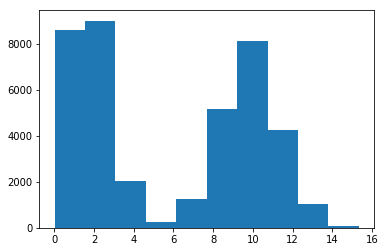

In [77]:
plt.hist(dist2[~np.eye(dist2.shape[0], dtype = bool)]);

In [83]:
tau_list = np.array([.5,1.,2,3,4,6,8,10,12,np.inf]) 

bar = progressbar.ProgressBar()
ldd_2d = list()
for tau in bar(tau_list):
    ldd_2d.append(local_distance_depth_function(dist2, tau))

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


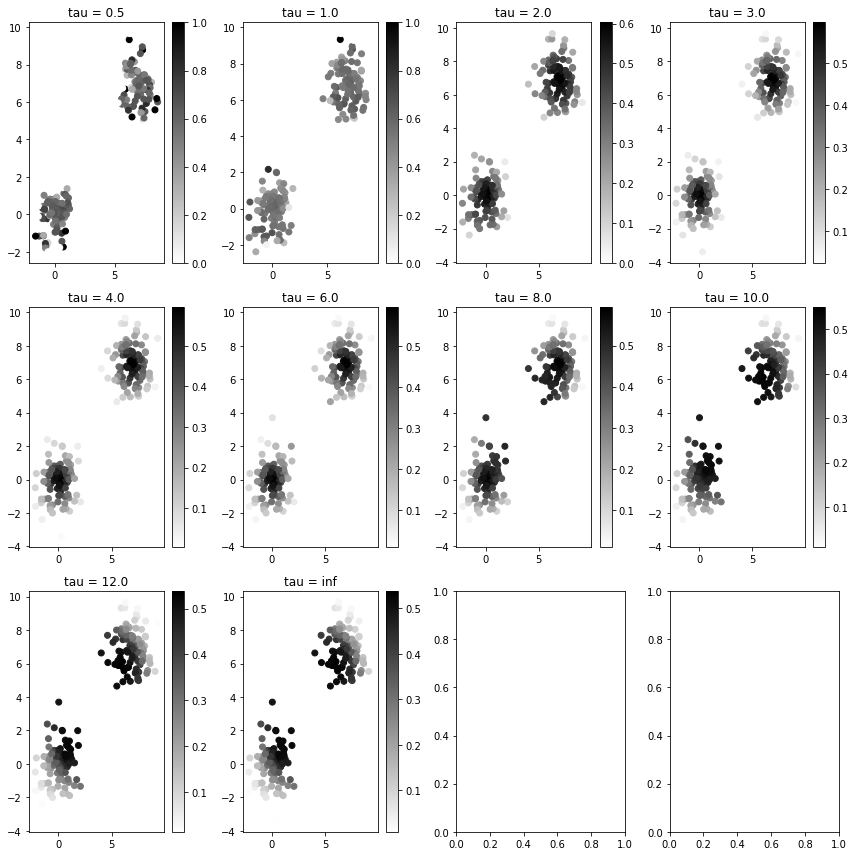

In [84]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

colorstuff = []

for idx, tau in enumerate(tau_list):
    ldd_2d_i = ldd_2d[idx]
    colorstuff.append(ax[idx].scatter(x = xsim2[:,0], y = xsim2[:,1], c = ldd_2d_i, cmap = 'binary'))
    ax[idx].set_title("tau = " + str(tau))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()

From the above we see that "outlyingness" isn't really preserved at too small $\tau$.

### example 2: 2 half moons (same variance)

In [85]:
import sklearn.datasets
n_data = 350*2
X, y = sklearn.datasets.make_moons(n_samples=n_data,
                                   noise=.1)

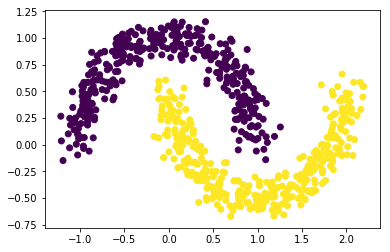

In [86]:
plt.scatter(X[:,0], X[:,1], c = y)

In [87]:
dist3 = scipy.spatial.distance_matrix(X,X)

(array([46028., 63848., 98416., 90342., 72662., 55284., 29400., 22130.,
        10866.,  1024.]),
 array([0.        , 0.34543673, 0.69087347, 1.0363102 , 1.38174694,
        1.72718367, 2.07262041, 2.41805714, 2.76349387, 3.10893061,
        3.45436734]),
 <a list of 10 Patch objects>)

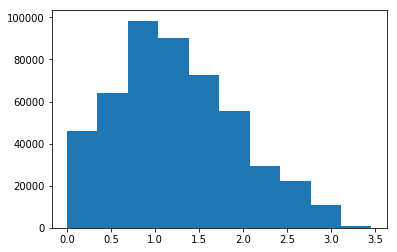

In [88]:
plt.hist(dist3.ravel())

In [89]:
tau_list = np.array([.25,.5,1,1.5,2.0,2.5,3,np.inf]) 

bar = progressbar.ProgressBar()
ldd_2d = list()
for tau in bar(tau_list):
    ldd_2d.append(local_distance_depth_function(dist3, tau))

100% (8 of 8) |##########################| Elapsed Time: 0:00:42 Time:  0:00:42


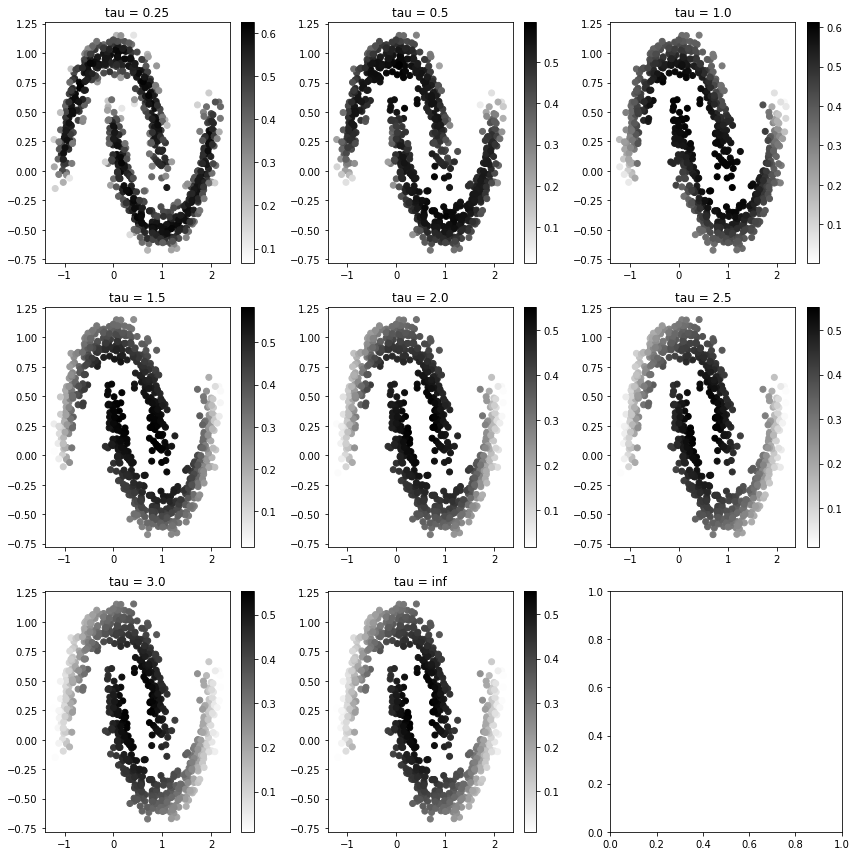

In [92]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
ax = ax.ravel()


first_iter = enumerate(tau_list)

colorstuff = []
for idx, tau in first_iter:
    ldd_2d_i = ldd_2d[idx]
    colorstuff.append(ax[idx].scatter(x = X[:,0], y = X[:,1], c = ldd_2d_i, 
                                      cmap = 'binary'))
    ax[idx].set_title("tau = " + str(tau))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()

### example 3: 2 guassians, different variance

In [93]:
xsim4 = np.random.normal(loc=(0,0), scale=(.5,.5), size=(100,2))
xsim4 = np.concatenate([xsim4, 
                        np.random.normal(loc=(7,7), 
                                         scale=(1.5,1.5), 
                                         size=(100,2))], 
                       axis = 0)

In [94]:
dist4 = scipy.spatial.distance_matrix(xsim4, xsim4)

(array([11208.,  5704.,  2372.,   724.,   610.,  2406.,  8228.,  5940.,
         2360.,   448.]),
 array([ 0.        ,  1.46169333,  2.92338666,  4.38507999,  5.84677332,
         7.30846665,  8.77015998, 10.23185331, 11.69354664, 13.15523997,
        14.61693329]),
 <a list of 10 Patch objects>)

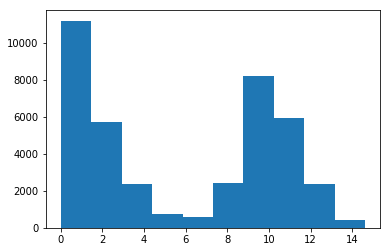

In [95]:
plt.hist(dist4.ravel())

In [98]:
tau_list = np.array([.5,1.,2,3,4,6,8,10,np.inf]) 

bar = progressbar.ProgressBar()
ldd_2d = list()
for tau in bar(tau_list):
    ldd_2d.append(local_distance_depth_function(dist4, tau))

N/A% (0 of 9) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100% (9 of 9) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


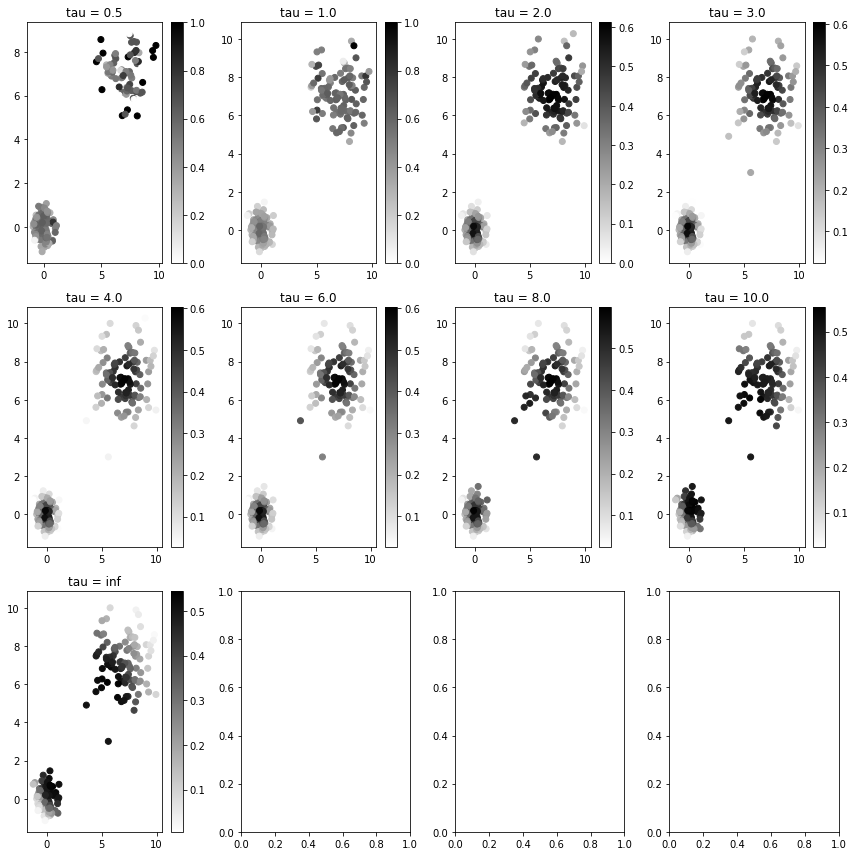

In [99]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (12,12))
ax = ax.ravel()

colorstuff = []

for idx, tau in enumerate(tau_list):
    ldd_2d_i = ldd_2d[idx]
    colorstuff.append(ax[idx].scatter(x = xsim4[:,0], y = xsim4[:,1], 
                                      c = ldd_2d_i, cmap = 'binary'))
    ax[idx].set_title("tau = " + str(tau))
    fig.colorbar(colorstuff[idx], ax = ax[idx])
fig.tight_layout()